# MLP Autoencoder

#### By [Natalí de Santi](https://natalidesanti.github.io), email: natalidesanti@gmail.com

In this notebook we will see an **image denoising** technique produced by a **MLP autoencoder**.

## 0) Summary

* Image denoising using CNN autoencoders
* Multi Layer Perceptrons Autoencoders
* Libraries
* Data
* Building the Autoencoder
* Training the model
* Testing the model

## 1) Image denoising using autoencoders

`Autoencoding` is a data compression algorithm where we have the **compression** and the **decompression** functions that are: 

_data-specific_, _lossy_, and _learned automatically from examples_.

That is the reason why that, differently from the _traditional methods_ we have seen before, this new category of _image denoising methods_
are purely **data-driven**, what means there is no need to phocus on a specific kind of noise.

A **autoencoder** can be a __deep Learning algorithm__ which takes an _input image_, assign _importance_ (learnable weight, biases and 
retains spatial relationships in the data into each one of theirs layers) to various aspects/parts in the image and is able to 
differentiate/reconstruct the same.

The general idea behind this kind of code can be visualized here:

![General autoencoder](https://www.pyimagesearch.com/wp-content/uploads/2020/02/keras_denoising_autoencoder_overview.png)
###### Figure: Example of a general autoencoder

Then, the **autoencoder** compreehends an _encoder_ and a _decoder_. 

The **encoder** does the _encoding process_, i.e., transforms the image into a _compressed representation_ at the same time that starts the noisy reduction. 

Then, the _compressed representation_ goes to **decoder** that performs the _decoder process_, restoring the image to its true and recognizable shape. 

The encoder and decoder are usually chosen as _parametric function_, here represented by **cneural networks**, and the _parameters_ of the encoding/decoding functions are optimized to minimize the **loss function**, which is a measure of the difference between the _denoised image_ and the _true_ one.

At the end of the process, we remove almost all noise in the image.

## 2) MLP Autoencoders

**Multi Layer Perceptrons** (MLPs) draw inspiration from biological neural systems, such as the brain, to process information. 

These algorithms propagate information through a layered architecture composed of activation units called **neurons** and their connections. 

Each neuron maintains its activation state, while the connections carry weights that multiply the input signals as they propagate through the network.

In MLPs, layers are often referred to as **dense layers** (also known as _fully connected layers_), and the MLP architecture is typically structured as a sequence of such layers.

In some sense these architectures are the root of any neural network.

![](https://images.newscientist.com/wp-content/uploads/2024/08/15111606/SEI_217467197.jpg)
###### Figure: Example of a MLP

dense Dense layers are specialized to discern **global patterns** within their feature space 

(e.g., patterns involving _all vector entries or all image pixels_, if compressed into a 1D array).

That is exactly what we are going to do here, while converting our images into 1D arrays!

## 3) Libraries

Once again, the libraries are subject to your installation (see notebook of image denoising).

Here, we will implement the **CNNautoencoder** using `keras`:

In [1]:
try:
    import keras
    from keras import layers
    from keras.datasets import mnist
    import numpy as np
    import matplotlib.pyplot as plt
    from keras import regularizers
except:
    from tensorflow import keras
    from tensorflow.keras import layers
    from tensorflow.keras.datasets import mnist
    import numpy as np
    import matplotlib.pyplot as plt
    from keras import regularizers

## 4) Data

As detailed in the first notebook, we are using as our data the [MNIST](https://keras.io/api/datasets/mnist/) dataset.

### Importing data

In [2]:
(x_train, _), (x_test, _) = mnist.load_data()

In [3]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

See that, here, we are going to define the variable **d2**, that will be responsible for taking care of the 1D flatennization of our images:

In [4]:
dimension = 28
d2 = dimension*dimension
dimension, d2

(28, 784)

### Pre-processing data

In [5]:
num_data = 10000
frac_train = 0.7
frac_test = 0.3
x_train = x_train[0:int(frac_train*num_data)]
x_test = x_test[0:int(frac_test*num_data)]

We are going to normalize the images between 0 and 1 and to reshape them (now to flattenizing them):

In [6]:
norm_factor = 255.
x_train = x_train.astype('float32')/norm_factor
x_test = x_test.astype('float32')/norm_factor
x_train = np.reshape(x_train, (x_train.shape[0], d2))
x_test = np.reshape(x_test, (x_test.shape[0], d2))
x_train.shape

(7000, 784)

Here, we need to noisy the images, then, we apply a Gaussian noisy matrix and clip the images between 0 and 1.

In [7]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc = 0.0, scale = 1.0, size = x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Visualizing some noise images images. Notice we are supposed to recover the image dimensions!

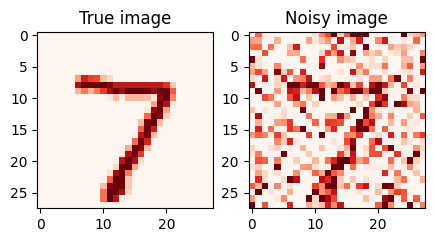

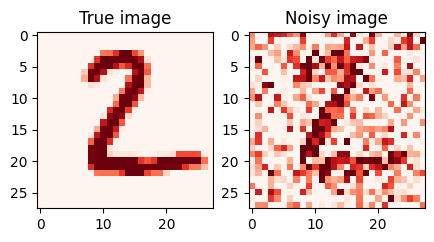

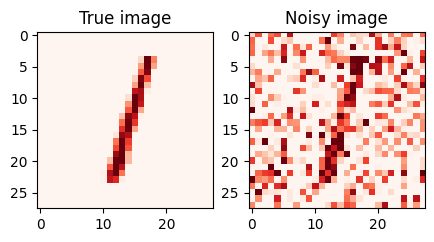

In [8]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 2)
    fig.set_size_inches(5, 5)
    axes[0].set_title('True image')
    im0 = axes[0].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Noisy image')
    im1 = axes[1].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')

## 5) Building the Autoencoder

Defining the input images for the **autoencoder**:

In [9]:
input_img = keras.Input(shape = (d2,))

### Encoder

The **encoder** will consist in a sequence of `Dense` layers, responsible to decrease the number of neurons per layer, encoding the images information.

Additionally, we are making use of `regularizers` to add a sparsity constraint on the encoded representations:

In [10]:
encoded = layers.Dense(16, activation = 'relu', activity_regularizer = regularizers.l1(10e-5))(input_img)
encoded = layers.Dense(8, activation = 'relu', activity_regularizer = regularizers.l1(10e-5))(encoded)

### Decoder

The **decoder** will consist in a sequence of `Dense` layers responsible to increase the number of neurons per layer, in order to recover the initial image shape:

In [11]:
decoded = layers.Dense(16, activation = 'relu')(encoded)
decoded = layers.Dense(d2, activation = 'sigmoid')(decoded)

### Autoencoder

Represents the junction of the **encoder** followed by the **decoder**:

In [12]:
autoencoder = keras.Model(input_img, decoded)

We can visualize the **autoencoder**:

In [13]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 16)                12560     
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 16)                144       
                                                                 
 dense_3 (Dense)             (None, 784)               13328     
                                                                 
Total params: 26168 (102.22 KB)
Trainable params: 26168 (102.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 6) Training the model

Before starting training, we have to configure our model to use a **per-pixel** `binary crossentropy` _loss_, and the `Adam` _optimizer_:

In [14]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

### Fitting

Time to learn how to denoise the image by fiting/training the method.

Notice that we are defining a portion of the training set to validate the model at each epoch:

In [15]:
validation_split = 0.1
history = autoencoder.fit(x_train_noisy, x_train, epochs = 40, batch_size = 20, shuffle = True, validation_split = validation_split)

Epoch 1/40
315/315 [==============================] - 0s 922us/step - loss: 0.3147 - val_loss: 0.2611
Epoch 2/40
315/315 [==============================] - 0s 727us/step - loss: 0.2616 - val_loss: 0.2418
Epoch 3/40
315/315 [==============================] - 0s 695us/step - loss: 0.2452 - val_loss: 0.2297
Epoch 4/40
315/315 [==============================] - 0s 691us/step - loss: 0.2276 - val_loss: 0.2137
Epoch 5/40
315/315 [==============================] - 0s 685us/step - loss: 0.2157 - val_loss: 0.2080
Epoch 6/40
315/315 [==============================] - 0s 691us/step - loss: 0.2096 - val_loss: 0.2042
Epoch 7/40
315/315 [==============================] - 0s 716us/step - loss: 0.2054 - val_loss: 0.2016
Epoch 8/40
315/315 [==============================] - 0s 701us/step - loss: 0.2024 - val_loss: 0.1998
Epoch 9/40
315/315 [==============================] - 0s 697us/step - loss: 0.2000 - val_loss: 0.1982
Epoch 10/40
315/315 [==============================] - 0s 694us/step - loss: 0.198

### Tracking the history of the training stage

Now, we can analise the model taking a look at the losses for the **training** and **validations** sets:

In [16]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [17]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

Visualizing the history of the training:

Text(0.5, 0, 'Epochs')

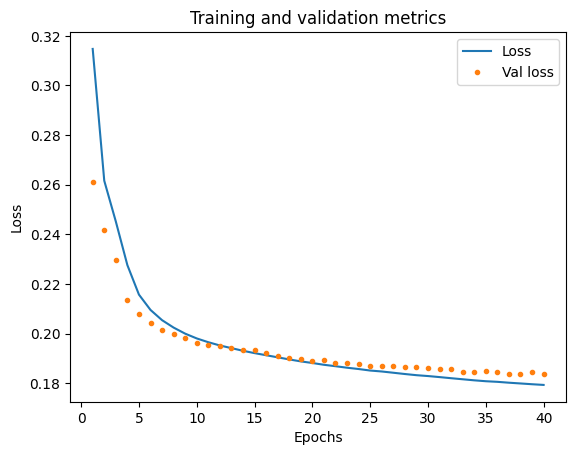

In [18]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, '.', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

## 7) Testing the model

We can now take a look at the performance of our model by _testing_ it on the _test set_:

In [19]:
all_denoised_images = autoencoder.predict(x_test_noisy)

94/94 [==============================] - 0s 345us/step


### Visual results

Here, we can compare our visual results looking side by side the noisy, targets and denoised  images.

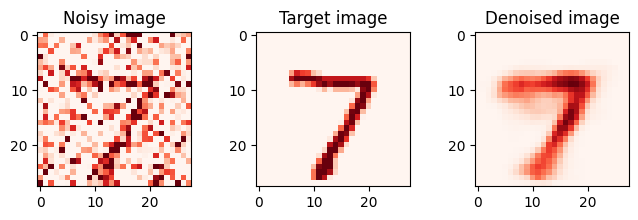

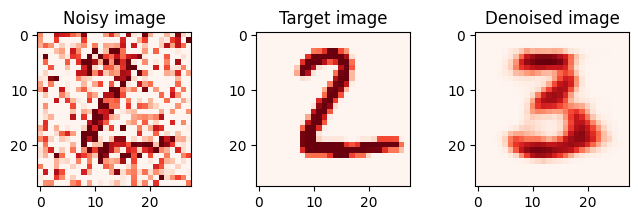

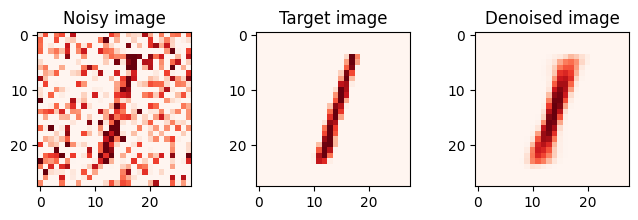

In [20]:
n = 3
for i in range(n):
    fig, axes = plt.subplots(1, 3)
    fig.set_size_inches(8, 2)
    axes[0].set_title('Noisy image')
    im0 = axes[0].imshow(x_test_noisy[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[1].set_title('Target image')
    im1 = axes[1].imshow(x_test[i].reshape(dimension, dimension), cmap = 'Reds')
    axes[2].set_title('Denoised image')
    im2 = axes[2].imshow(all_denoised_images[i].reshape(dimension, dimension), cmap = 'Reds')

It is interesting to see that we have finally **removed all the noise**, in contrast to all the previous traditional methods.

However, the hand-written numbers were not well recovered, still being a bit blurred and with some mistakes, what is the case of digit 2!

## References

[1] FAN, L. et al. Brief review of image denoising techniques. Visual Computing for Industry, Biomedicine, and Art, v. 2, 2019.

[2] Tian, C. et al. Deep Learning on Image Denoising: An overview. arXiv e-prints, p. arXiv:1912.13171, dez. 2019.

[3] Chollet, F. [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

[4] de SANTI, N. S. M. Machine learning methods for extracting cosmological information. 2024. doi: [10.11606/T.43.2024.tde-15072024-101341](https://www.teses.usp.br/teses/disponiveis/43/43134/tde-15072024-101341/en.php).